In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from scipy import stats

In [4]:
df = pd.read_csv('fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
numerical_variables = ['lower_salary_range', 'higher_salary_range', 'salary_range_difference']
cat_variables = ['salary_present', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education']

In [6]:
#split salary range into 2 new columns: lower_salary_range and higher_salary_range
df[['lower_salary_range','higher_salary_range']] = df.salary_range.str.split('-', expand=True)
df['lower_salary_range'] = df['lower_salary_range'].astype(float).astype('Int64')
df['higher_salary_range'] = df['higher_salary_range'].astype(float).astype('Int64')

#initialise new column: salary_range_difference
df['salary_range_difference'] = df['higher_salary_range'] - df['lower_salary_range']

#if salary range only contains a single value, set higher_salary_range = lower_salary_range
df.loc[df['salary_range'].notnull() & df['salary_range_difference'].isnull(), 'higher_salary_range'] = df['lower_salary_range']

#recalculate salary_range_difference
df['salary_range_difference'] = df['higher_salary_range'] - df['lower_salary_range']

#check if salary range present
df['salary_present'] = np.where(df.salary_range.notnull(), 1, 0)

#reposition columns
lower_salary_range = df.pop('lower_salary_range')
higher_salary_range = df.pop('higher_salary_range')
salary_range_difference = df.pop('salary_range_difference')
salary_present = df.pop('salary_present')

df.insert(4, "salary_present", salary_present)
df.insert(6, "lower_salary_range", lower_salary_range)
df.insert(7, "higher_salary_range", higher_salary_range)
df.insert(8, "salary_range_difference", salary_range_difference)

In [7]:
df['lower_salary_range'] = df['lower_salary_range'].astype(float)
df['higher_salary_range'] = df['higher_salary_range'].astype(float)
df['salary_range_difference'] = df['salary_range_difference'].astype(float)

descriptive_stats = df[numerical_variables].describe().loc[['mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['mean', 'std', 'median']
descriptive_stats['mode'] = df[numerical_variables].mode().transpose()[0]
## descriptive_stats['mad'] = [stats.median_abs_deviation(data[x]) for x in numerical_variables]
descriptive_stats['kurtosis'] = [stats.kurtosis(df[x], fisher=False, nan_policy='omit') for x in numerical_variables]
descriptive_stats['excess kurtosis'] = [stats.kurtosis(df[x], fisher=True, nan_policy='omit') for x in numerical_variables]
descriptive_stats['skewness'] = [stats.skew(df[x], nan_policy='omit') for x in numerical_variables]

descriptive_stats

,mean,std,median,mode,kurtosis,excess kurtosis,skewness
lower_salary_range,511142.318340,1.761277e+07,35000.0,0.0,1707.058081,1704.058081,40.585744
higher_salary_range,805340.521967,2.692975e+07,50000.0,50000.0,1642.644776,1639.644776,39.923283
salary_range_difference,294198.203626,9.348074e+06,10000.0,10000.0,1534.922341,1531.922341,38.771929


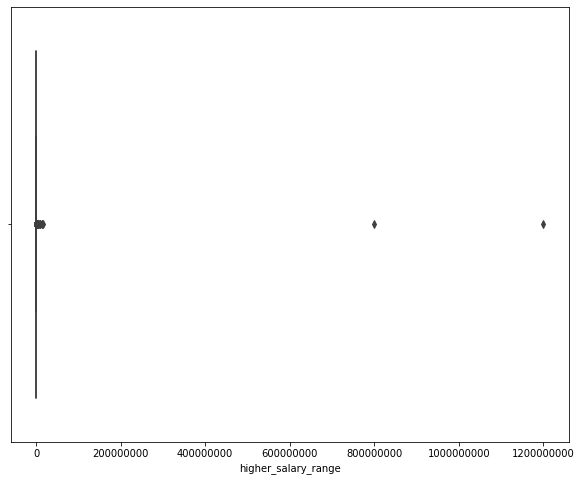

In [8]:
plt.figure(figsize = (10, 8))
sns.boxplot(x="higher_salary_range", data=df)
plt.ticklabel_format(style='plain', axis='x')

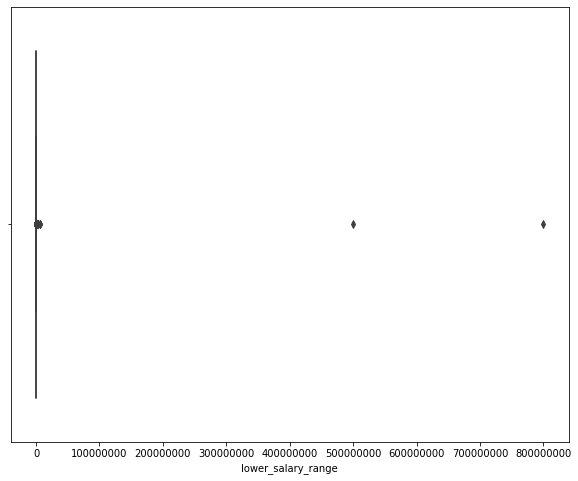

In [9]:
plt.figure(figsize = (10, 8))
sns.boxplot(x="lower_salary_range", data=df)
plt.ticklabel_format(style='plain', axis='x')

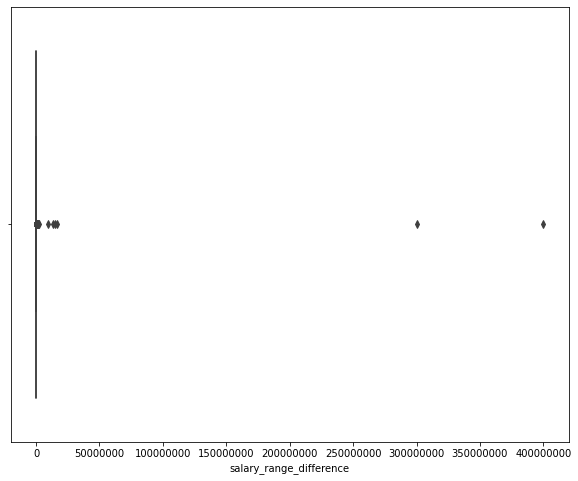

In [10]:
plt.figure(figsize = (10, 8))
sns.boxplot(x="salary_range_difference", data=df)
plt.ticklabel_format(style='plain', axis='x')

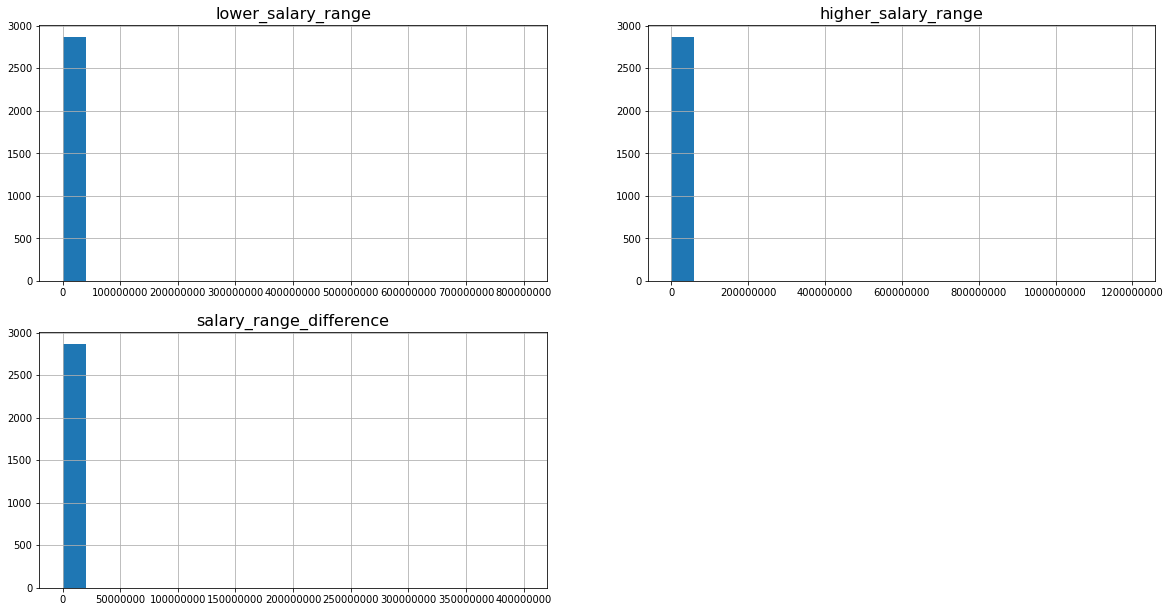

In [11]:
plt.figure(figsize=(20,16))
plt.subplot(321)

axes = [None] * len(numerical_variables)

for index, name in enumerate(df[numerical_variables].columns):
    axes[index] = plt.subplot(3, 2, index+1, label=str(index))
    df[name].hist(ax=axes[index], bins=20)
    axes[index].set_title(name, fontsize=16)
    plt.ticklabel_format(style='plain', axis='x')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_id                   17880 non-null  int64  
 1   title                    17880 non-null  object 
 2   location                 17534 non-null  object 
 3   department               6333 non-null   object 
 4   salary_present           17880 non-null  int32  
 5   salary_range             2868 non-null   object 
 6   lower_salary_range       2868 non-null   float64
 7   higher_salary_range      2868 non-null   float64
 8   salary_range_difference  2868 non-null   float64
 9   company_profile          14572 non-null  object 
 10  description              17879 non-null  object 
 11  requirements             15185 non-null  object 
 12  benefits                 10670 non-null  object 
 13  telecommuting            17880 non-null  int64  
 14  has_company_logo      

In [13]:
df.isnull().sum()

job_id                         0
title                          0
location                     346
department                 11547
salary_present                 0
salary_range               15012
lower_salary_range         15012
higher_salary_range        15012
salary_range_difference    15012
company_profile             3308
description                    1
requirements                2695
benefits                    7210
telecommuting                  0
has_company_logo               0
has_questions                  0
employment_type             3471
required_experience         7050
required_education          8105
industry                    4903
function                    6455
fraudulent                     0
dtype: int64

In [14]:
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

job_id                      0.00
title                       0.00
location                    1.94
department                 64.58
salary_present              0.00
salary_range               83.96
lower_salary_range         83.96
higher_salary_range        83.96
salary_range_difference    83.96
company_profile            18.50
description                 0.01
requirements               15.07
benefits                   40.32
telecommuting               0.00
has_company_logo            0.00
has_questions               0.00
employment_type            19.41
required_experience        39.43
required_education         45.33
industry                   27.42
function                   36.10
fraudulent                  0.00
dtype: float64

In [15]:
df.fillna('', inplace=True)
fraud_df = df[df['fraudulent'] == 1]
no_fraud_df = df[df['fraudulent'] == 0]
df.isnull().sum()

job_id                     0
title                      0
location                   0
department                 0
salary_present             0
salary_range               0
lower_salary_range         0
higher_salary_range        0
salary_range_difference    0
company_profile            0
description                0
requirements               0
benefits                   0
telecommuting              0
has_company_logo           0
has_questions              0
employment_type            0
required_experience        0
required_education         0
industry                   0
function                   0
fraudulent                 0
dtype: int64

Number of real (label as 0) and fake jobs (label as 1) in the dataset :
0    17014
1      866
Name: fraudulent, dtype: int64


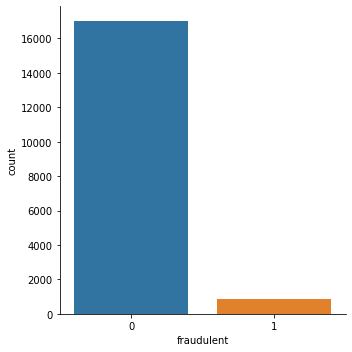

In [16]:
print("Number of real (label as 0) and fake jobs (label as 1) in the dataset :")


print(df["fraudulent"].value_counts())
sns.catplot(x="fraudulent", data = df, kind = "count")

Text(0.5, 1.0, 'Correlation Heatmap')

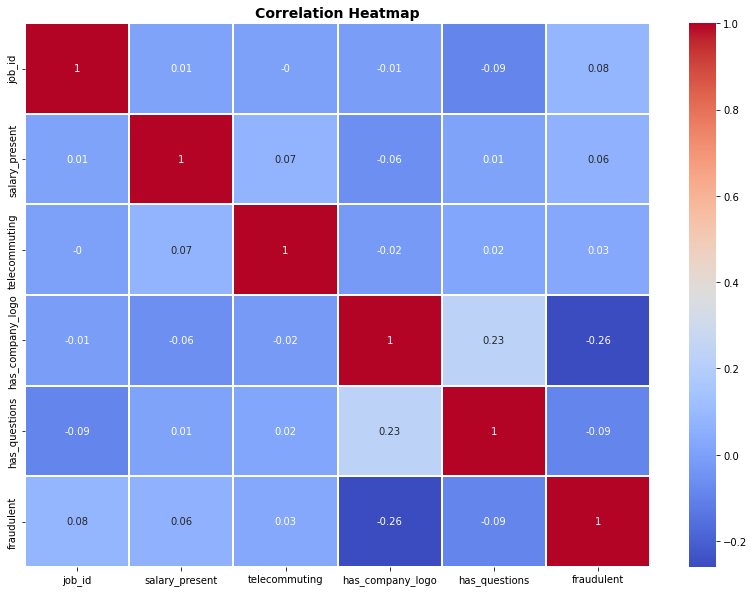

In [17]:
plt.figure(figsize=(14, 10))
hm = sns.heatmap(round(df.corr(),2), cmap="coolwarm",annot=True, linewidths=.05)
plt.title("Correlation Heatmap", fontsize=14, fontweight='bold')

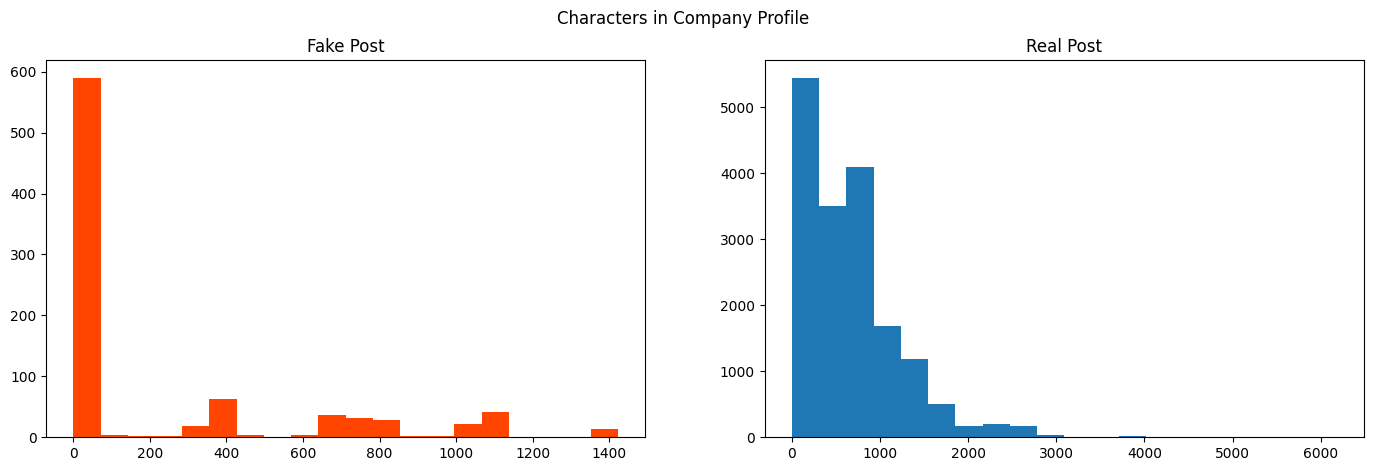

In [18]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)

#counting the number of characters for frauduelent df
length=df[df["fraudulent"]==1]['company_profile'].str.len()

#plotting the histogram
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')

#counting the number of characters for non frauduelent df
length=df[df["fraudulent"]==0]['company_profile'].str.len()

#plotting the histogram
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in Company Profile')
plt.show()

fake postings in the variable company profile has lesser characters and that if there is more that 1500 characters the post is likely to be a real post.

In [19]:
def get_comparison(fraud_df, no_fraud_df, col_name):
    fraud_freq = fraud_df[col_name].value_counts().apply(lambda x: x / len(fraud_df)).rename('Fraud')
    no_fraud_freq = no_fraud_df[col_name].value_counts().apply(lambda x: x / len(no_fraud_df)).rename('Not Fraud')
    emp_df = pd.concat([no_fraud_freq, fraud_freq],axis=1)
    emp_df.plot(kind='bar', figsize=(14,10), rot=1)
    plt.title(f"{col_name} distribution grouped by fraud or not fraud")
    plt.xlabel(col_name)
    plt.ylabel("Percantage")
    plt.show()

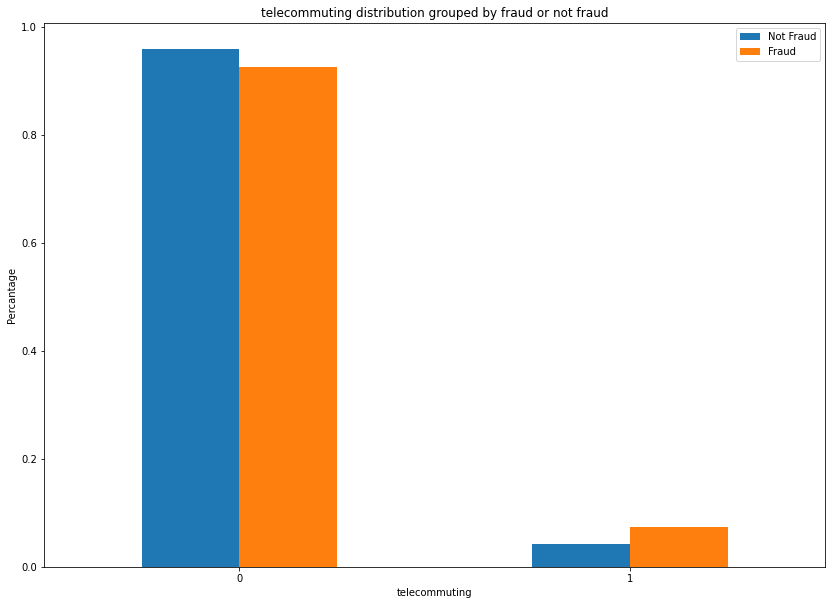

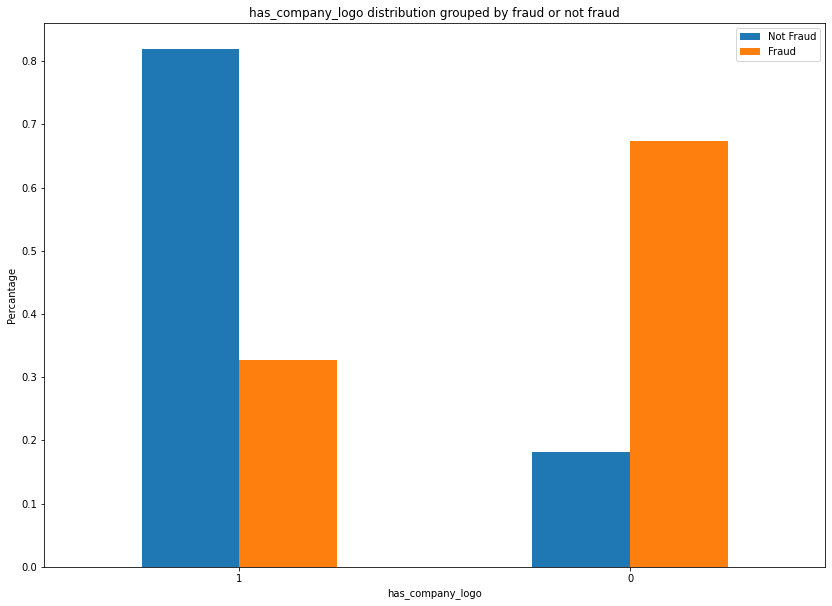

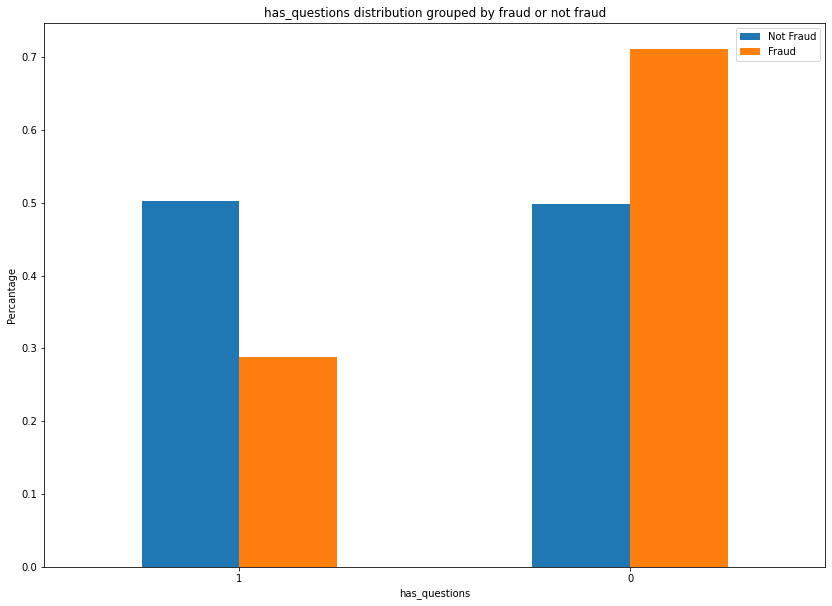

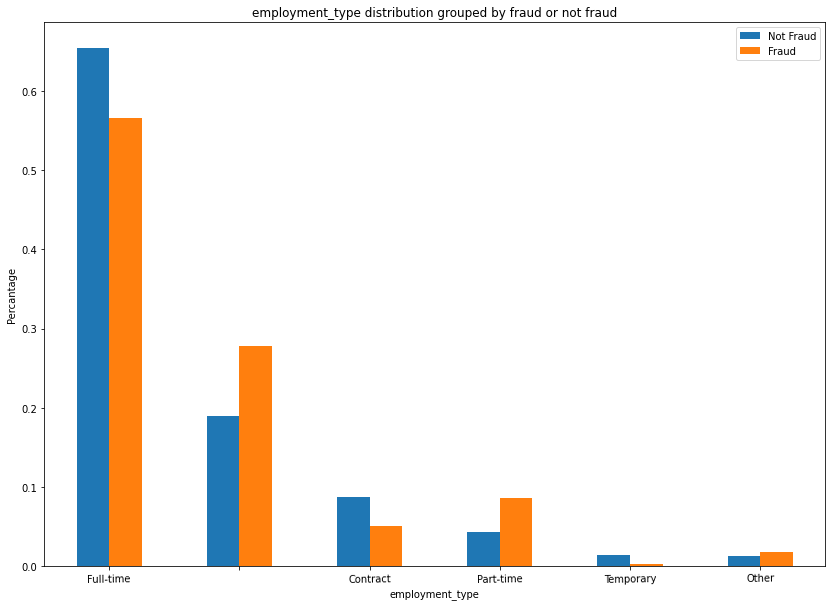

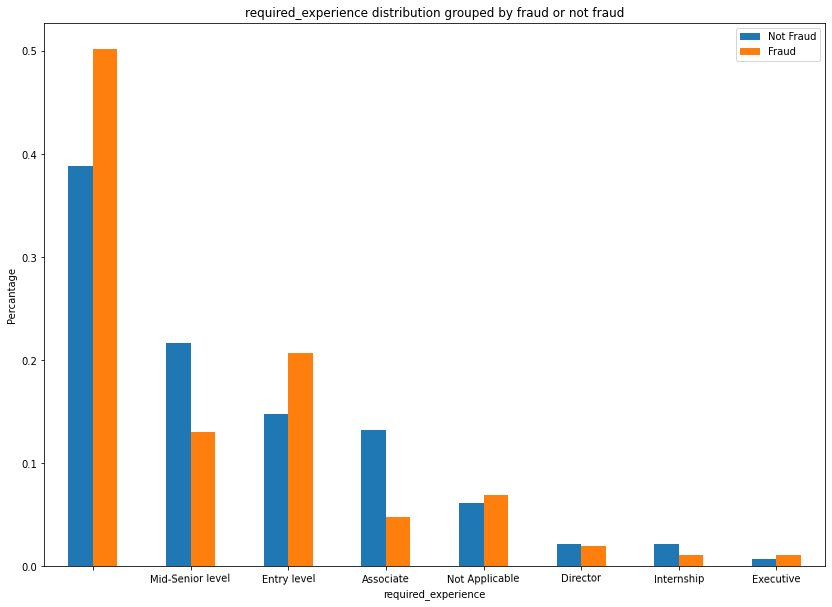

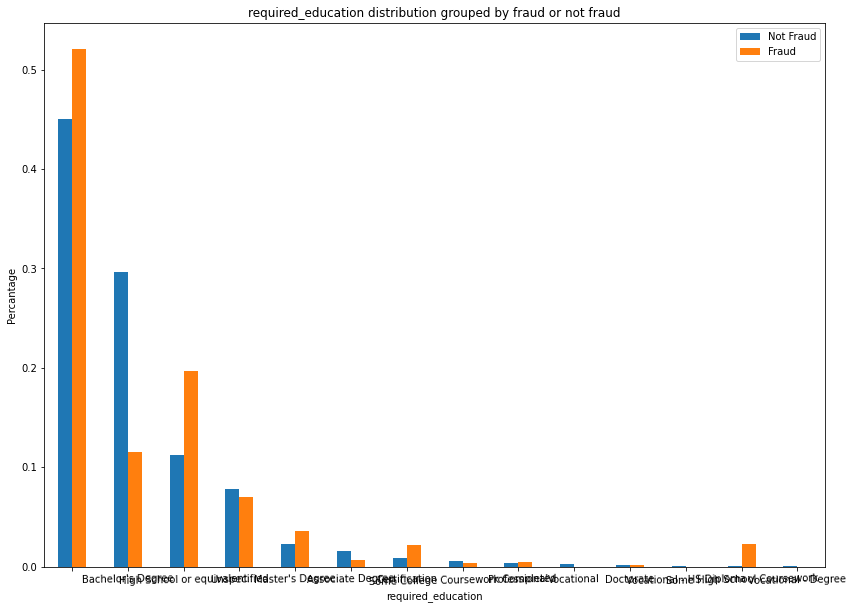

In [20]:
cat_col_names = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education']
for col in cat_col_names:
    get_comparison(fraud_df, no_fraud_df, col)

In [21]:
#remove columns not required for next steps 
columns=['job_id','telecommuting','has_company_logo','has_questions', 'salary_range','salary_present', 'lower_salary_range', 'higher_salary_range', 'salary_range_difference', 'employment_type']

for colu in columns:
    del df[colu]
def split(location):
    l = location.split(',')
    return l[0]
df['country'] = df.location.apply(split)

In [22]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


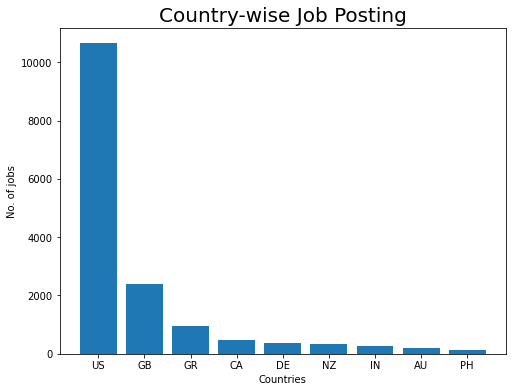

In [23]:
#identify the different country related to the job posting and remove those empty columns
countr= dict(df.country.value_counts()[:10])
del countr['']
countr
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(countr.keys(), countr.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)
plt.show()

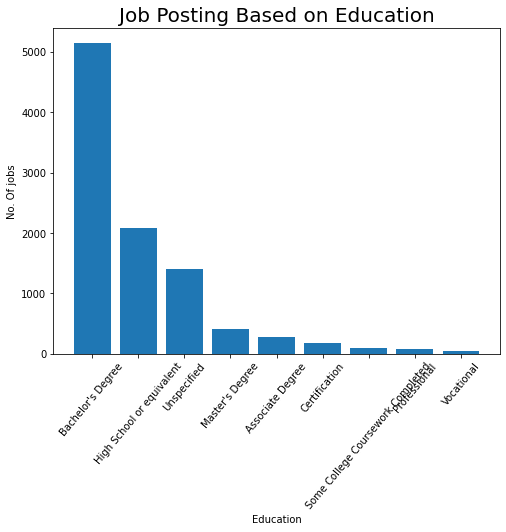

In [24]:
#understand job posting based on education and remove those with empty columns
edu =  dict(df.required_education.value_counts()[:10])
del edu['']
edu
plt.figure(figsize=(8,6))
plt.title('Job Posting Based on Education',size=20)
plt.bar(edu.keys(),edu.values())
plt.ylabel('No. Of jobs',size=10)
plt.xlabel('Education', size=10)
plt.xticks(rotation=50)
plt.show()

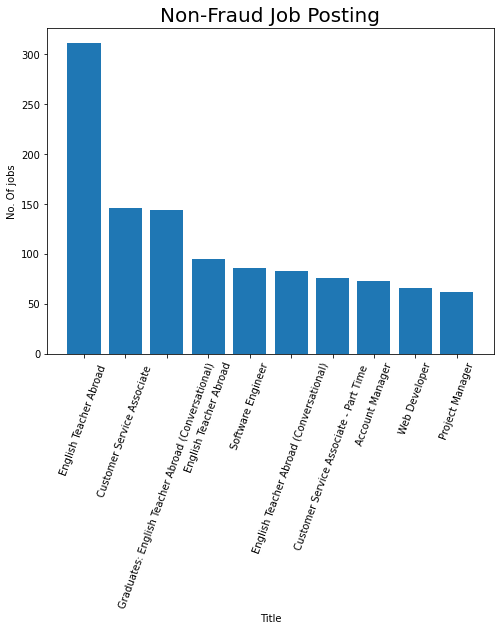

In [25]:
#understand top 10 non fraud posting based on titles
#print(df[df.fraudulent==0].title.value_counts()[:10])
nfraud = dict(df[df.fraudulent==0].title.value_counts()[:10])

plt.figure(figsize=(8,6))
plt.title('Non-Fraud Job Posting',size=20)
plt.bar(nfraud.keys(),nfraud.values())
plt.ylabel('No. Of jobs',size=10)
plt.xlabel('Title', size=10)
plt.xticks(rotation=70)
plt.show()

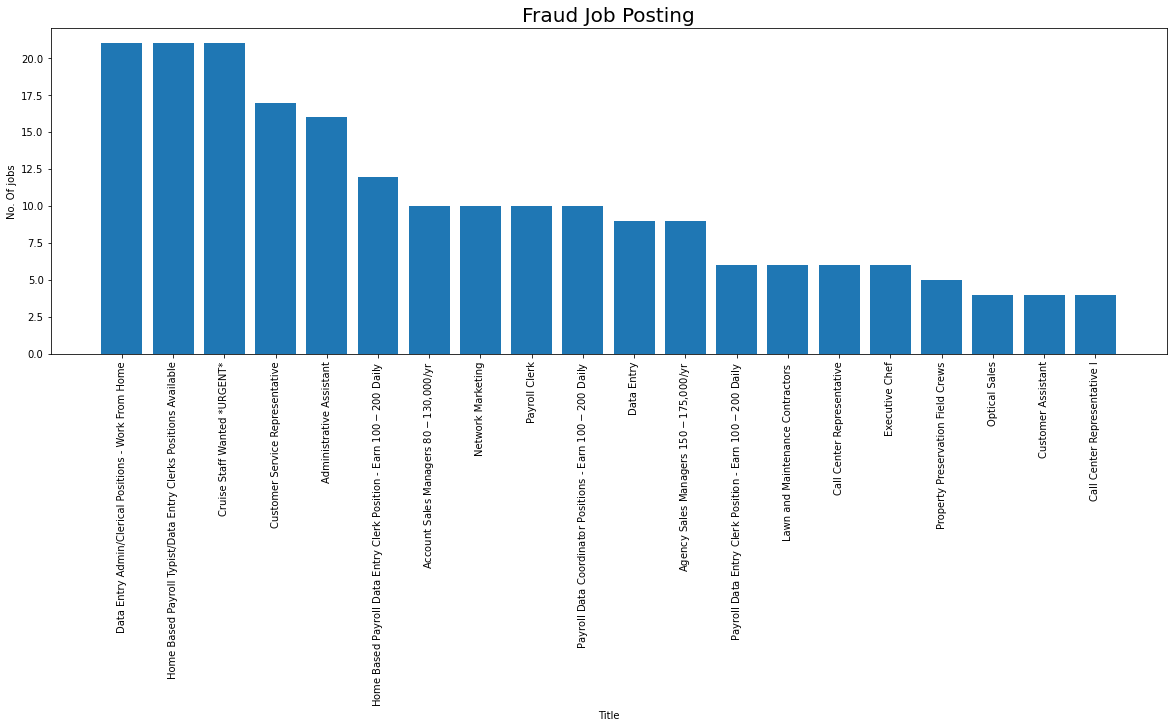

In [26]:
#understand top 20 fraud posting based on titles 
#print(df[df.fraudulent==1].title.value_counts()[:10])
fraud = dict(df[df.fraudulent==1].title.value_counts()[:20])

plt.figure(figsize=(20,6))
plt.title('Fraud Job Posting',size=20)
plt.bar(fraud.keys(),fraud.values())
plt.ylabel('No. Of jobs',size=10)
plt.xlabel('Title', size=10)
plt.xticks(rotation=90)
plt.show()